# Transit-Only Fit Example: TOI-1269 A b

## Importing ExoMUSE and required libraries

In [148]:
#We first use %matplotlib inline to display the plots in the notebook.
%matplotlib inline

In [149]:
#We then import the required libraries.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

import corner
import radvel

import os
import sys
import astropy.time

import lightkurve as lk

In [150]:
#We then import the ExoMUSE codes.
sys.path.insert(0, '../../ExoMUSE/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import ExoMUSE_fit.py, ExoMUSE_utils.py, and ExoMUSE_gaiasource.py as standards.
import ExoMUSE_fit
import ExoMUSE_utils
import ExoMUSE_gaiasource

reload(ExoMUSE_fit)

ExoMUSE_fit, ExoMUSE_utils, ExoMUSE_gaiasource

list.remove(x): x not in list


(<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_fit.py'>,
 <module 'ExoMUSE_utils' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_utils.py'>,
 <module 'ExoMUSE_gaiasource' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_gaiasource.py'>)

In [151]:
#We also import rcParams to keep our plots consistent throughout various notebooks.
from matplotlib import rcParams

#We change the formating of the plots.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## Data Input

In [152]:
#We import the datasets.
#Since this is an Transit-Only Fit we import:
    #Transit Data

#Instead of importing the transit data, we can also download it using lightkurve library.
#For this we first define the name of our target.
target_name = "TIC 288735205"

#We then look for the light curve data of this target using lightkurve.
#For the exposure time, we pick 120 seconds (2 minutes).
#Note that the search may take a while depending on the target and available data.
data_search = lk.search_lightcurve(target_name, sector = [14], exptime = 120)

data_search

SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   288735205      0.0
  1 TESS Sector 14 2019  TASOC     120   288735205      0.0

In [153]:
#We select one of the datasets from our data search results.
selected_lc_data = data_search[0]

selected_lc_data

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   288735205      0.0

In [154]:
#We then download the selected light curve data.
#Note that the download may take a while depending on the size of the dataset.
lc_data = selected_lc_data.download()

lc_data

<TessLightCurve length=18423 LABEL="TIC 288735205" SECTOR=14 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
       Time           float32     ...    float32        float32    
------------------ -------------- ... -------------- --------------
1683.3528362042173  5.6987217e+03 ... -7.8932615e-03  2.1998238e-02
1683.3542251107913  5.6904448e+03 ... -9.7945146e-03  2.3174286e-02
1683.3556140172493  5.6734961e+03 ... -5.3399121e-03  2.4093786e-02
1683.3570029238228  5.6942749e+03 ... -4.3086726e-03  2.8180597e-02
1683.3583918302797  5.7021743e+03 ... -6.4680995e-03  2.0410107e-02
 1683.359780736854  5.6795830e+03 ... -6.1248783e-03  2.2656962e-02
 1683.361169643428  5.6986670e+03 ... -3.2429972e-03  2.8810883e-02
 1683.362558549886  5.6994858e+03 ... -5.7237111e-03  2.6342876e-02
  1683.36394745646  5.6841943e+03 ... -3.7874421e-03  2.1140782e-02
               ...            ... ...            ...            ...
1710.1921559225568  5.6662739e+03 ... -1.5074033e-02  4.2198277e-03
1710.1935448419952  5.7020083e+03 ... -1.9242106e-02  8.8387532e-03
1710.1949337613748  5.6761797e+03 ... -1.4653190e-02  1.2509299e-02
1710.1963226808705  5.6851772e+03 ... -1.8345451e-02  1.2807851e-03
1710.1977116003088  5.6902559e+03 ... -1.7298801e-02  4.9639028e-03
1710.1991005197476  5.6830479e+03 ... -1.8165521e-02  9.3733026e-03
1710.2004894391855  5.6902529e+03 ... -1.5144596e-02  2.7310068e-03
 1710.201878358623  5.6718735e+03 ... -1.6276462e-02  6.9603571e-03
1710.2032672781186  5.6921968e+03 ... -2.0961272e-02  6.2083653e-03

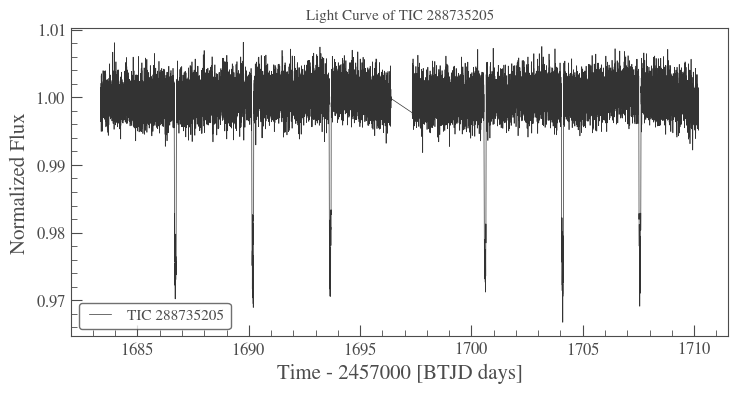

In [155]:
#We then remove possible "Not a Number (NaN)" values from the light curve data.
#We also normalize the fluxes to 1 on the same code line.
lc = lc_data[lc_data.flux.value > 0].remove_nans().normalize()

#We can then quickly plot the light curve data.
lc.plot()
plt.title(f"Light Curve of {target_name}")
plt.show()

In [156]:
#We then define raw datas of time, flux, and flux error as arrays.
t = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value.filled(np.nan)

In [157]:
#We can also mask out the data depending on the quality value.
quality = lc.quality.value
mask = quality == 0

#We then setup a dataframe that contains the time, flux, and flux error values.
df = pd.DataFrame()
df["time"] = t[mask]
df["flux"] = flux[mask]
df["flux_err"] = flux_err[mask]

df

time      flux  flux_err
0      1683.352836  1.000825  0.001886
1      1683.354225  0.999371  0.001885
2      1683.355614  0.996394  0.001884
3      1683.357003  1.000044  0.001886
4      1683.358392  1.001431  0.001887
...            ...       ...       ...
18418  1710.197712  0.999338  0.001882
18419  1710.199101  0.998072  0.001878
18420  1710.200489  0.999337  0.001878
18421  1710.201878  0.996109  0.001877
18422  1710.203267  0.999679  0.001879

[18423 rows x 3 columns]

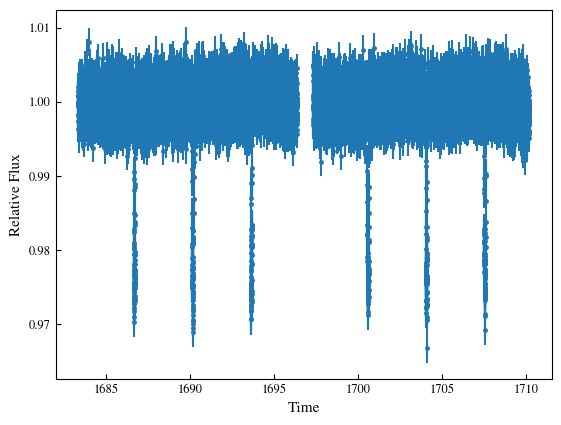

In [158]:
#We can also mask out the parts where there are no transits.
#For this, we first plot out how the light curve data looks like.
plt.errorbar(df["time"].values, df["flux"].values, df["flux_err"].values, fmt=".")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)
plt.show()

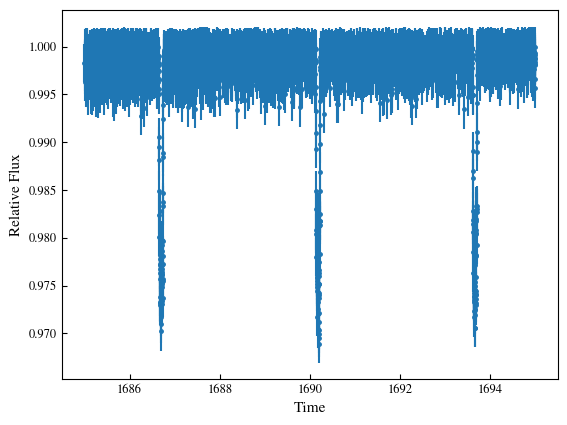

In [159]:
#We then mask out a part of the light curve data (due to memory issues).
mask = (t >= 1685) & (t <= 1695) & (flux <= 1.000)

#We then apply this mask to our dataframe.
t = t[mask]
flux = flux[mask]
flux_err = flux_err[mask]

#We can then plot the masked light curve data.
plt.errorbar(t, flux, flux_err, fmt=".")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)
plt.show()

## Setting up the Priors 

In [160]:
#We then import the Prior file for the Transit-Only Fit.
f = "../../data/lcpriors/TOI1259A_PriorsLC.txt"

reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_fit.py'>

## Setting up the Log-Likelihood

In [161]:
#We then pull time, flux and flux errors from the arrays that we have masked.
t = t
flux = flux
e_flux = flux_err

#We then use "LPFunctionTransit" for the Transit-Only Fit.
    #"LPFunction" => Log-Likelihood Function
    #"Transit" => Transit-Only Fit

#We setup our Log-Likelihood Function by using the dataset and the prior file.
#Note that this function prints out the Priors.
L = ExoMUSE_fit.LPFunctionTransitOnly(t, flux, e_flux, file_priors = f)

Reading in priorfile from ../../data/lcpriors/TOI1259A_PriorsLC.txt
   prior         arg1       arg2     label description priortype  fixed
0     NP     3.477978   0.000002      P_p1        P_p1     model  False
1     NP    12.314000   0.056000      a_p1        a_p1     model  False
2     NP  1686.700531   0.000104     t0_p1       t0_p1     model  False
3     FP     0.000000   0.000000    ecc_p1      ecc_p1     model   True
4     FP    90.000000  90.000000  omega_p1    omega_p1     model   True
5     NP     0.065000   0.055000      b_p1        b_p1     model  False
6     NP     0.147620   0.000350      p_p1        p_p1     model  False
7     NP     0.103140   0.000200   tdur_p1     tdur_p1     model  False
8     UP     0.100000   1.000000        u1          u1     model  False
9     UP     0.100000   1.000000        u2          u2     model  False
10    FP     0.000000   0.000000     gamma       gamma     model   True
11    FP     0.001389   0.001389   exptime     exptime     model   T

In [162]:
#We then define a fitting object by using the Log-Likelihood as follows.
TF = ExoMUSE_fit.ExoMUSEfitTransitOnly(L)

## Setting up the MCMC run

In [163]:
#For the MCMC, we use pyDE and emcee.
#We use pyDE to find the initial points for the chains.
#We then use emcee.EnsembleSampler to run the MCMC chains.
#This is all done by .minimize_pyDE() function from ExoMUSE_Fit.
    #de_iter => Differential Evolution iterations, used for the distribution of walkers.
        #To distribute better, we increase de_iter.
        #However, this would increase the initial optimization time.
    #mc_iter => MCMC iterations, used for the number of steps in the chains.
        #We can evaluate the chains using GR Statistic and/or Autocorrelation time.
        #Depending on the evaluations, we can increase the mc_iter.
        #However, this will of course increase the time of the MCMC run.

TF.minimize_PyDE(de_iter=8000,mc_iter=8000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels      centers        lower        upper           pv   center_dist
0      P_p1     3.477978     3.477968     3.477987     3.477978  5.571931e-08
1      a_p1    12.314000    12.034000    12.594000    12.313709  2.909644e-04
2     t0_p1  1686.700531  1686.700011  1686.701051  1686.700481  5.049042e-05
3      b_p1     0.065000    -0.210000     0.340000     0.179579 -1.145788e-01
4      p_p1     0.147620     0.145870     0.149370     0.147270  3.497585e-04
5   tdur_p1     0.103140     0.102140     0.104140     0.103024  1.164633e-04
6        u1     0.550000     0.100000     1.000000     0.309072  2.409275e-01
7        u2     0.550000     0.100000     1.000000     0.341496  2.085038e-01
8  sigma_tr     0.250000     0.000000     0.500000     0.000134  2.498658e-01
LogPost value: 16246.750809833191
LnL value: 16209.715316902642
Log priors 37.03549293054862
Running MCMC
MCMC iterations= 8000
0 1 2 3 4 5 6 7 8 9 10 11 12 1

## Flattening the Chains

In [164]:
#We can define the burn-in period to be the first 1000 steps.
#This means that we will discard the first 1000 samples from each chain.
burnin_index = 1000

#We then discard the first 1000 samples from all of the chains as follows.
    #First part: We take all the chains.
    #Second part: We discard the first 1000 samples per chain.
    #Third part: We take all the parameters that were in the MCMC run.
chains_after_burnin = TF.sampler.chain[ : , burnin_index : , : ]

#We then have to reshape the chains to obtain the flatchain as follows.
    #TF.lpf => ExoMUSE_fit.LPFunctionTransitOnly
    #.ps_vary => The Prior Set of the parameters that vary (from priors.py)
    #.priors => The priors of the varying parameters.
flatchain = chains_after_burnin.reshape((-1, len(TF.lpf.ps_vary.priors)))

In [165]:
#To store the posteriors from the flatchain, we can define a pandas DataFrame.
    #This time TF.lpf.ps_vary.labels takes the name of the varying parameters.
df_post = pd.DataFrame(flatchain, columns = TF.lpf.ps_vary.labels)

df_post

P_p1       a_p1        t0_p1      b_p1      p_p1   tdur_p1  \
0       3.477976  12.297337  1686.700537  0.167964  0.146690  0.103090   
1       3.477976  12.297337  1686.700537  0.167964  0.146690  0.103090   
2       3.477976  12.297337  1686.700537  0.167964  0.146690  0.103090   
3       3.477976  12.296037  1686.700542  0.172549  0.146667  0.103079   
4       3.477976  12.296037  1686.700542  0.172549  0.146667  0.103079   
...          ...        ...          ...       ...       ...       ...   
699995  3.477979  12.274257  1686.700507  0.196210  0.146643  0.102935   
699996  3.477979  12.303710  1686.700521  0.224569  0.146583  0.102988   
699997  3.477979  12.303710  1686.700521  0.224569  0.146583  0.102988   
699998  3.477979  12.303710  1686.700521  0.224569  0.146583  0.102988   
699999  3.477979  12.310005  1686.700530  0.216828  0.146687  0.103000   

              u1        u2  sigma_tr  
0       0.304853  0.425452  0.000292  
1       0.304853  0.425452  0.000292  
2       0.304853  0.425452  0.000292  
3       0.316653  0.409644  0.000278  
4       0.316653  0.409644  0.000278  
...          ...       ...       ...  
699995  0.429169  0.220684  0.000128  
699996  0.449179  0.210931  0.000067  
699997  0.449179  0.210931  0.000067  
699998  0.449179  0.210931  0.000067  
699999  0.430335  0.231053  0.000091  

[700000 rows x 9 columns]

## Assessing the Chains

In [166]:
#To check and assess the chains, we can use mcmc_help.
import mcmc_help

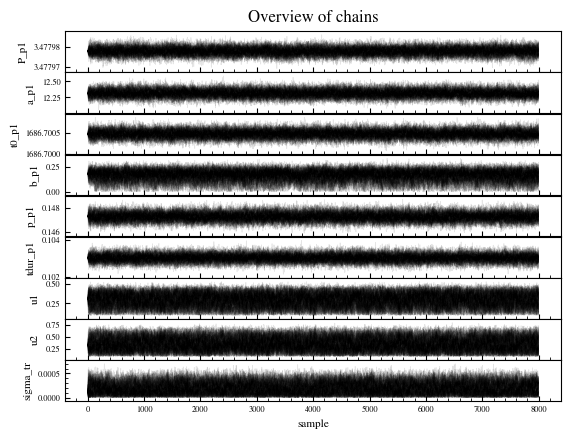

In [167]:
#We use the plot_chains function from the mcmc_help module to plot the chains.
#Note that TF.sampler is equivalent to an emcee.EnsembleSampler object.
mcmc_help.plot_chains(TF.sampler.chain, labels = TF.lpf.ps_vary.labels)

plt.show();

In [168]:
#We can also check the Gelman-Rubin (GR) Statistic to evaluate the chains of each parameter.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR Statistics:")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
print(50 * "-")

GR Statistics:
--------------------------------------------------
[1.00685261 1.00824824 1.00827855 1.01009399 1.00786029 1.00868851
 1.00950972 1.00861878 1.0076655 ]
--------------------------------------------------


In [169]:
#We can also check the autocorrelation time of the chains.
#If the chain isn't long enough, we would get the following error:
    #The chain is shorter than 50 times the integrated autocorrelation time for x parameter(s).
    #Use this estimate with caution and run a longer chain: N/50 = 40

try:
    print(50 * "-")
    print("Autocorrelation Time")
    print(50 * "-")
    tau = TF.sampler.get_autocorr_time()
    print(tau)

    #We can also divide the length of the chain by the autocorrelation time to get the number of s
    #independent samples.
    print(50 * "-")
    print("Number of Independent Samples")
    print(50 * "-")
    N_eff = len(flatchain) / tau
    print(N_eff)
    print(50 * "-")
    
except Exception as e:
    print("Error calculating the autocorrelation time:", e)
print(50 * "-")


--------------------------------------------------
Autocorrelation Time
--------------------------------------------------
[109.03774009 108.18173294 106.06476086 107.56647703 107.8966984
 105.58766548 120.0267643  121.11144223 116.94041111]
--------------------------------------------------
Number of Independent Samples
--------------------------------------------------
[6419.79556294 6470.59333362 6599.74146302 6507.60366349 6487.68692987
 6629.56223927 5832.03258112 5779.80071182 5985.95467025]
--------------------------------------------------
--------------------------------------------------


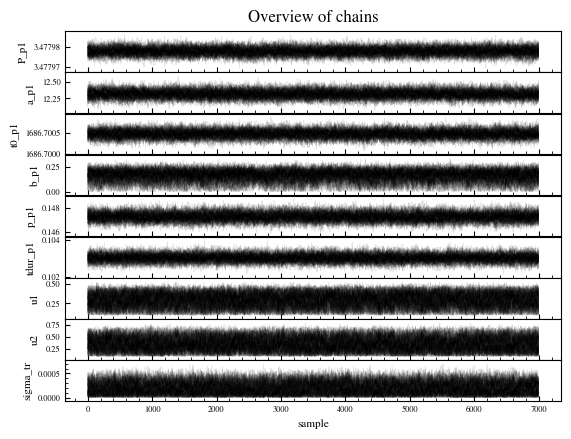

In [170]:
#We can also check how the flatchains look by plotting the flatchains.
mcmc_help.plot_chains(chains_after_burnin, labels = TF.lpf.ps_vary.labels)
plt.show();

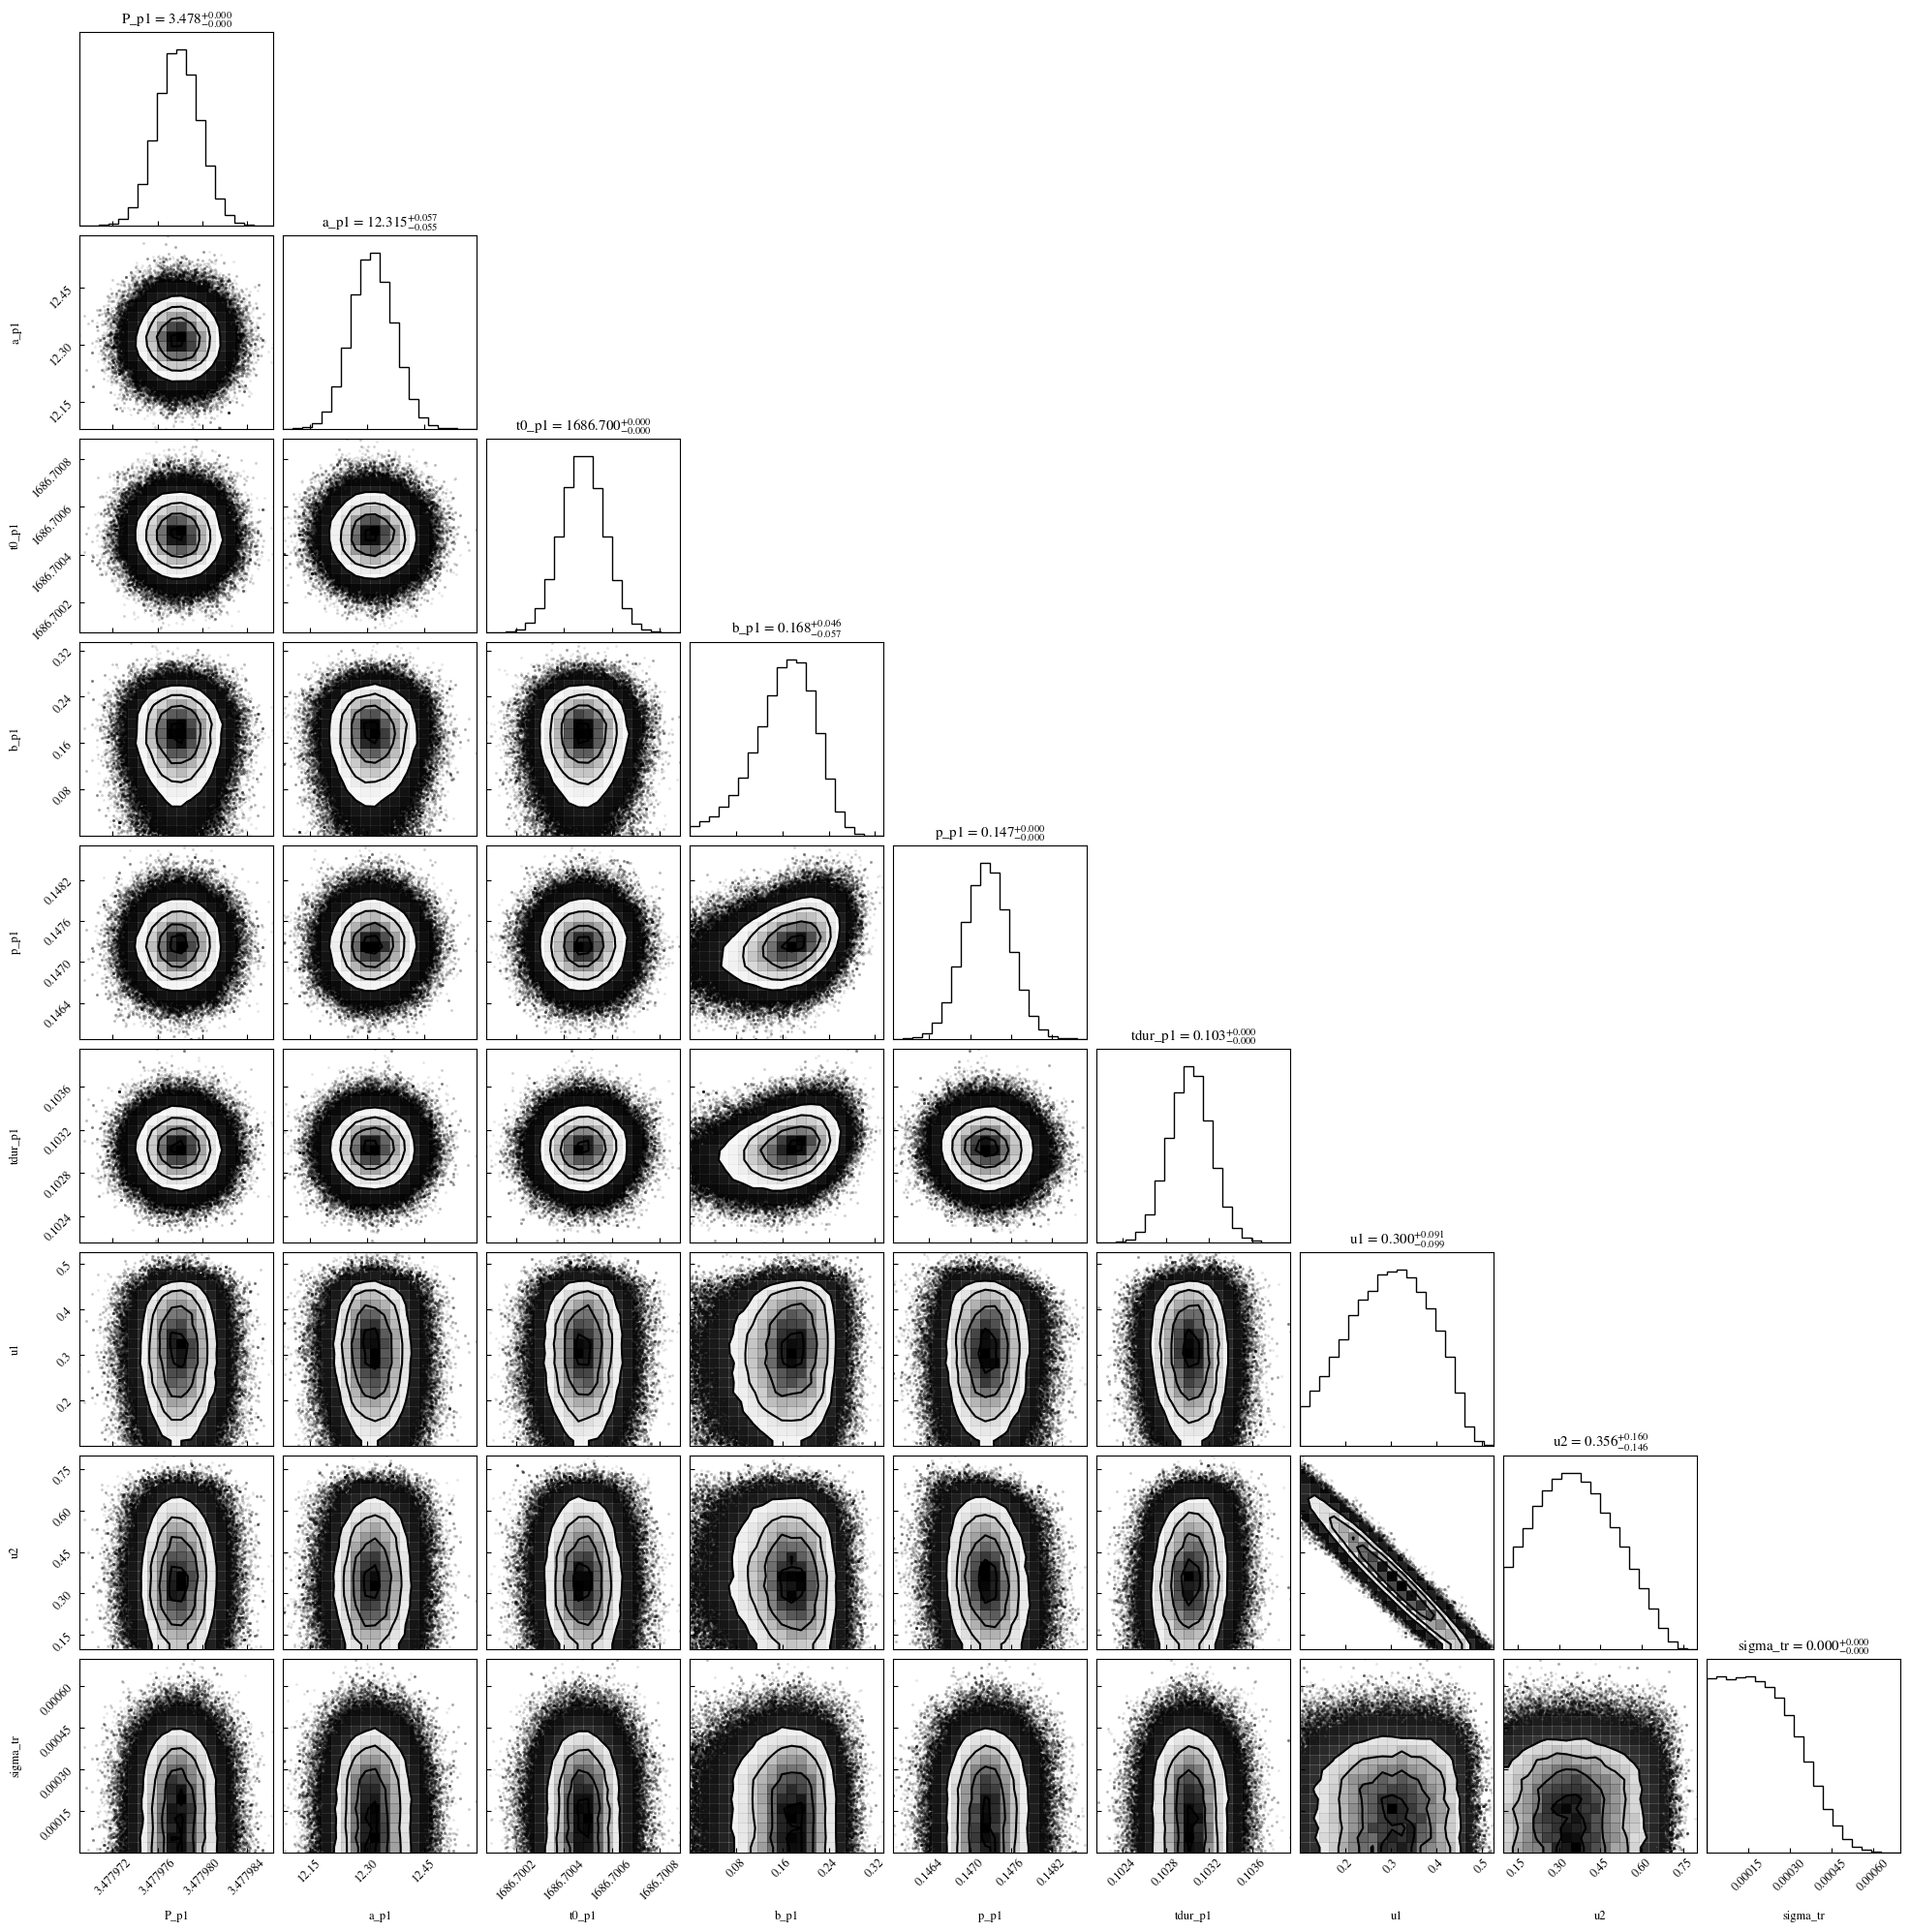

In [171]:
#We can also plot the corner plot to see the correlations and the posterior distributions
#of each parameter that was in the MCMC run.
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

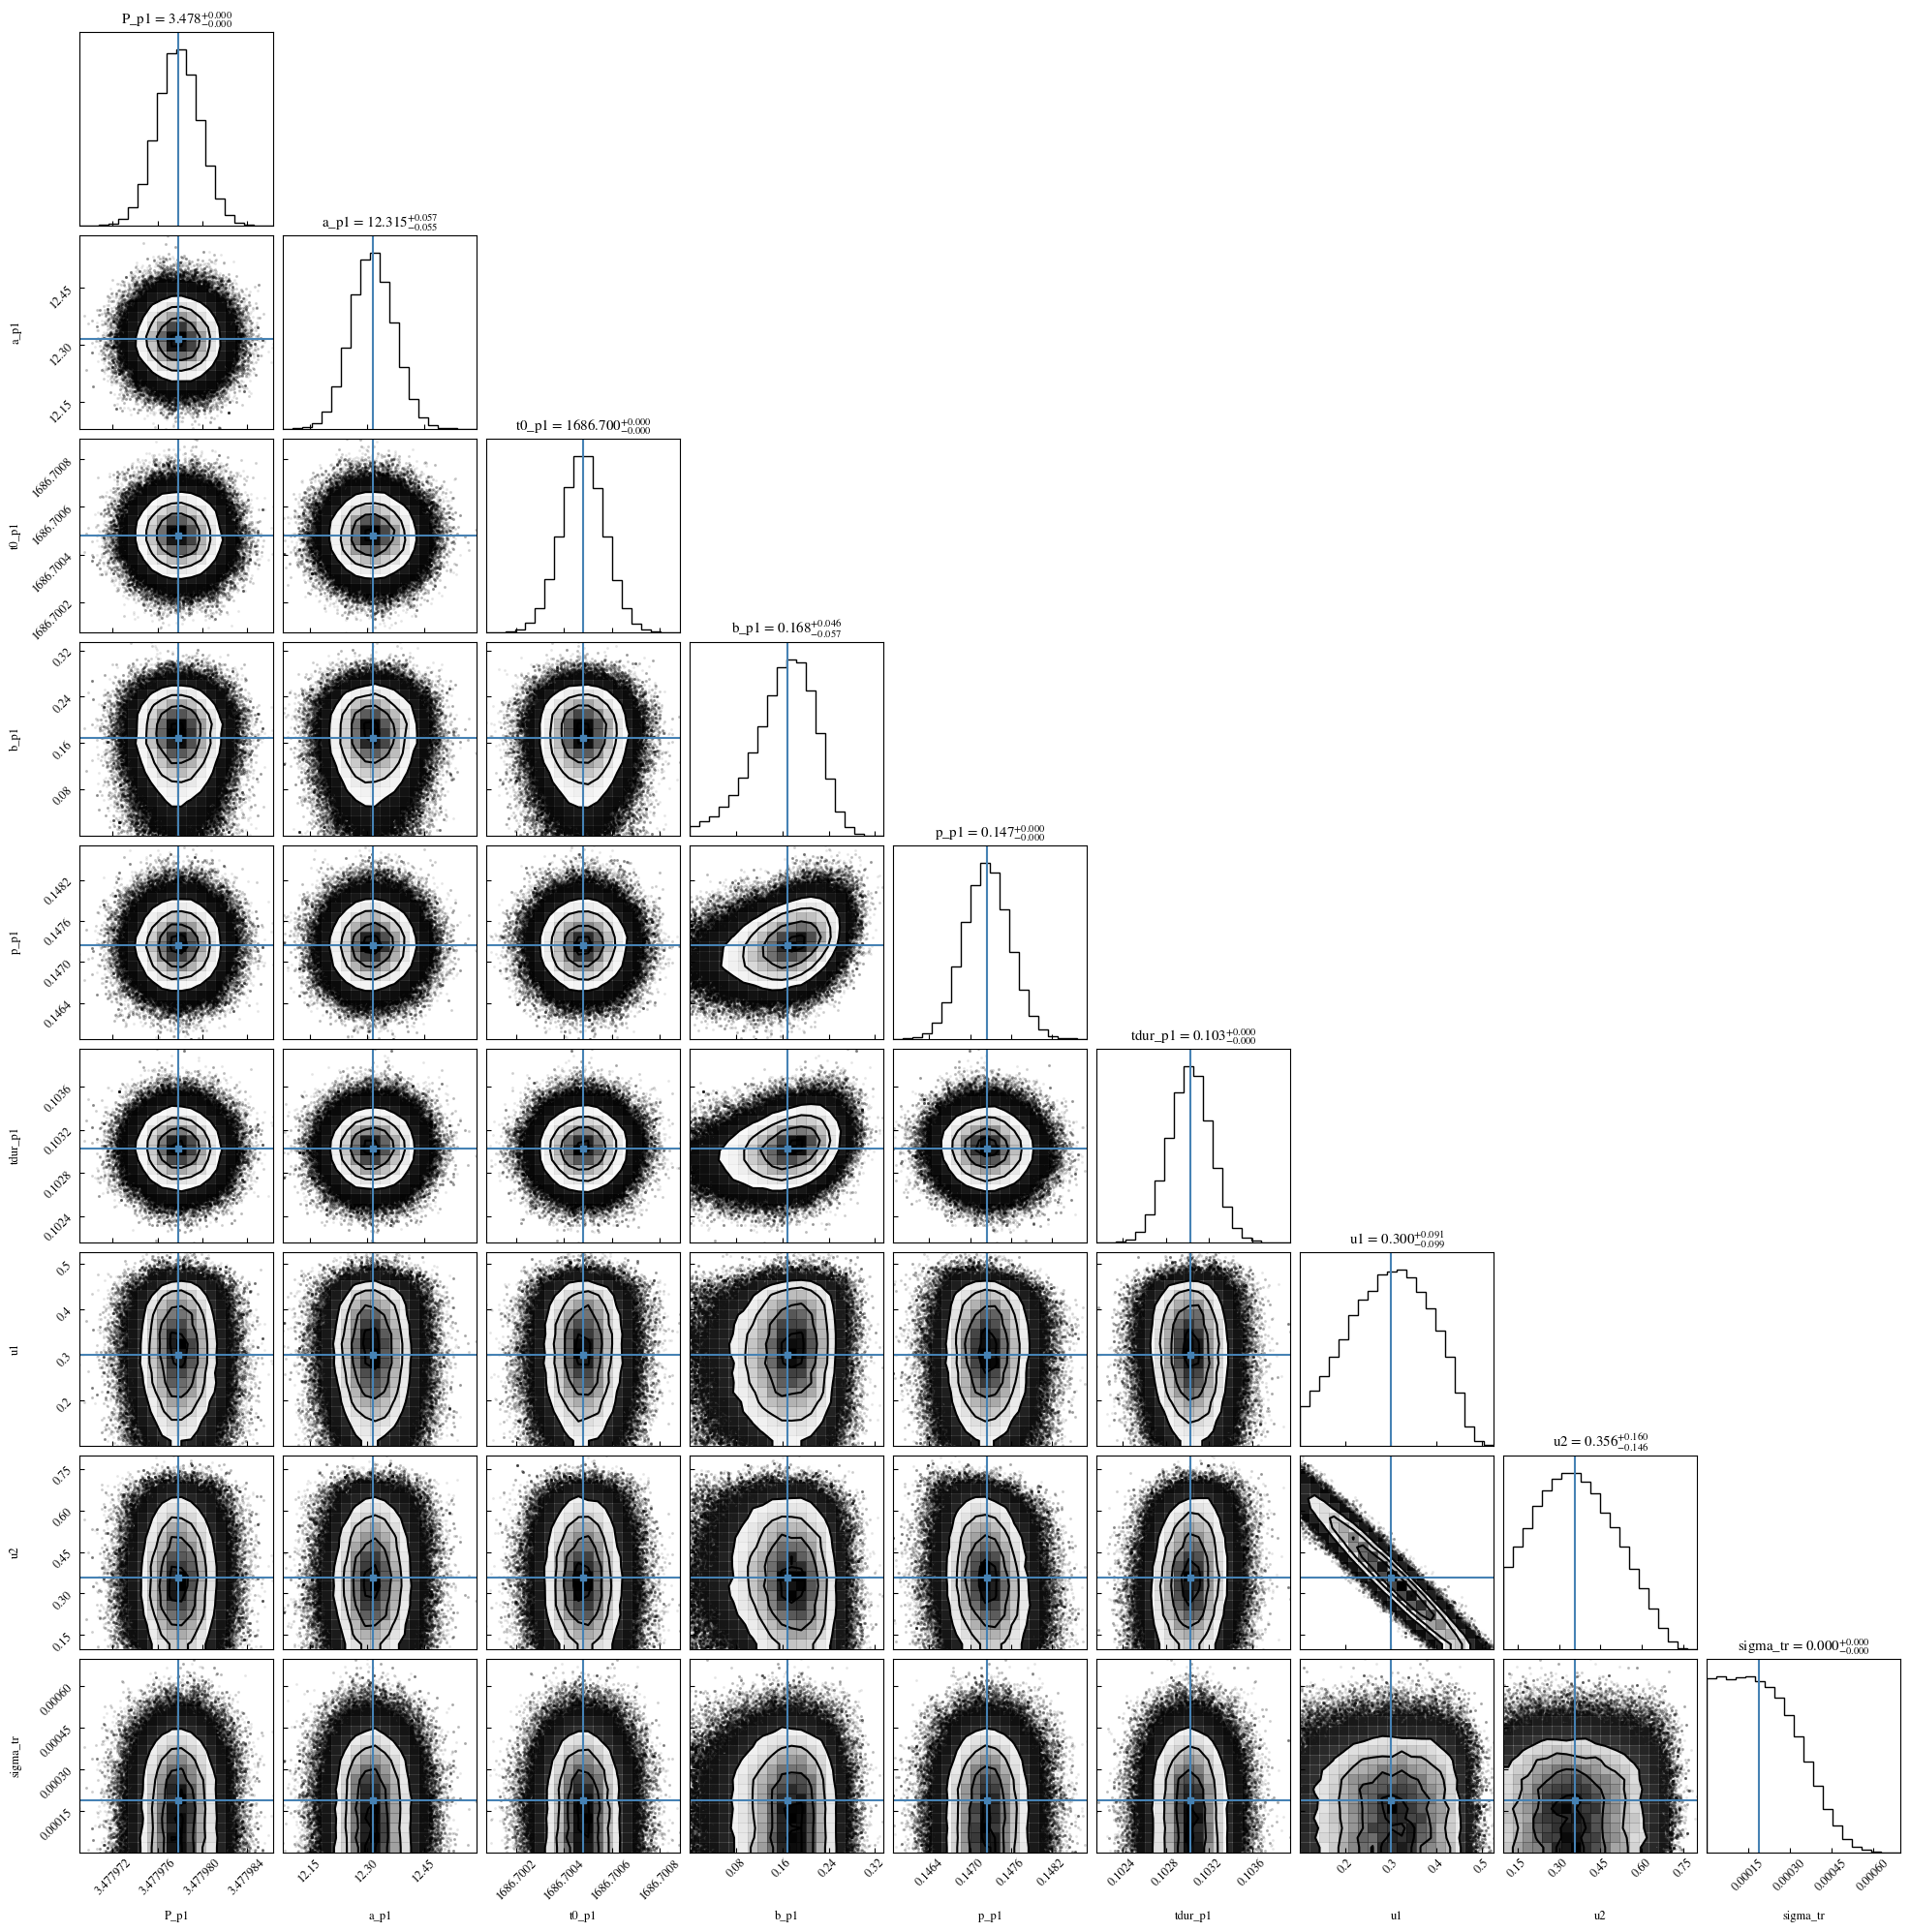

In [172]:
#We can also plot the corner plot with 50th percentile, i.e., the median to see whether
#the posterior distributions are sampled correctly or not.
#We first find the median of each parameter.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We then plot the corner plot and the median.
corner.corner(df_post.iloc[:, :].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

## Working with the Posteriors

In [173]:
#We can obtain the median and uncertainties of each parameter by using the
#.get_mean_values_mcmc_posteriors() function from ExoMUSE_fit.LPFunctionTransitOnly.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)

df_medvals

medvals     minus      plus                               values  \
0     3.477978  0.000002  0.000002  $3.4779779_{-0.000002}^{+0.000002}$   
0    12.314762  0.054587  0.056592           $12.315_{-0.055}^{+0.057}$   
0  1686.700480  0.000089  0.000089   $1686.70048_{-0.00009}^{+0.00009}$   
0     0.168323  0.057454  0.046344            $0.168_{-0.057}^{+0.046}$   
0     0.147249  0.000332  0.000336      $0.14725_{-0.00033}^{+0.00034}$   
0     0.103028  0.000194  0.000190      $0.10303_{-0.00019}^{+0.00019}$   
0     0.300034  0.099321  0.090929              $0.3_{-0.099}^{+0.091}$   
0     0.355934  0.146362  0.160107               $0.36_{-0.15}^{+0.16}$   
0     0.000187  0.000127  0.000147      $0.00019_{-0.00013}^{+0.00015}$   

     Labels Description  
0      P_p1        P_p1  
0      a_p1        a_p1  
0     t0_p1       t0_p1  
0      b_p1        b_p1  
0      p_p1        p_p1  
0   tdur_p1     tdur_p1  
0        u1          u1  
0        u2          u2  
0  sigma_tr    sigma_tr

In [174]:
df_medvals[["Labels", "values"]]

Labels                               values
0      P_p1  $3.4779779_{-0.000002}^{+0.000002}$
0      a_p1           $12.315_{-0.055}^{+0.057}$
0     t0_p1   $1686.70048_{-0.00009}^{+0.00009}$
0      b_p1            $0.168_{-0.057}^{+0.046}$
0      p_p1      $0.14725_{-0.00033}^{+0.00034}$
0   tdur_p1      $0.10303_{-0.00019}^{+0.00019}$
0        u1              $0.3_{-0.099}^{+0.091}$
0        u2               $0.36_{-0.15}^{+0.16}$
0  sigma_tr      $0.00019_{-0.00013}^{+0.00015}$

## Plotting the Data and the Best-Fit Model

In [175]:
#We first define the Title and the amount of times we will sample the model.
TITLE = "TOI-1259 A Transit-Only Fit"
NUM_SAMPLES = 5000

### Plotting the Data and the Best-Fit Model over Time

In [176]:
#We can first plot the data and the best-fit model over time.
    #Optional: If there we want to convert Julian Dates into Datetimes, i.e. DD-MM-YYYY format,
    #we can use ExoMUSE_utils.jd2datetime(times) function, where times is in Julian Dates.

#For this, we first get the times from our dataset.
times_data = TF.lpf.data["x"]

times_data

array([1685.00007858, 1685.00146749, 1685.0028564 , ..., 1694.99188598,
       1694.9932749 , 1694.99605272])

In [177]:
#We first get the medians of the parameters by using the flatchain.
#This again can be obtained by checking the 50th percentile of the flatchains.
pv_50 = np.percentile(flatchain, [50], axis=0)[0]

#We then define the amount of times where we will sample the Best-Fit Model.
times_model = np.linspace(times_data.min(), times_data.max(), NUM_SAMPLES)

#We then compute the best-fit model by using the median values and defined times.
tr_model = TF.lpf.compute_total_model(pv_50, times_model)

#We also compute the radial velocity data from the model at the observation times.
tr_data_from_model = TF.lpf.compute_total_model(pv_50, times_data)

#From here, we can calculate the residuals, i.e., DATA - MODEL
residuals = TF.lpf.data["y"] - tr_data_from_model

In [178]:
#We can also plot the uncertainty intervals of our model.
#For this, we can define the following loop that does:
    #1-) Sample a random vector of parameters from the flatchain. E.g. 200th chain
    #2-) Compute the Transit curve using the sampled parameter set/vector.
    #3-) Add this Transit curve model to a list.
    #4-) Sample from this list to get the uncertainty intervals.

#For this we first define a list to store all of the Transit models.
tr_models_for_uncertainty = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    tr_models_for_uncertainty.append(model)

#We then convert this list to an array.
tr_models_for_uncertainty = np.array(tr_models_for_uncertainty)

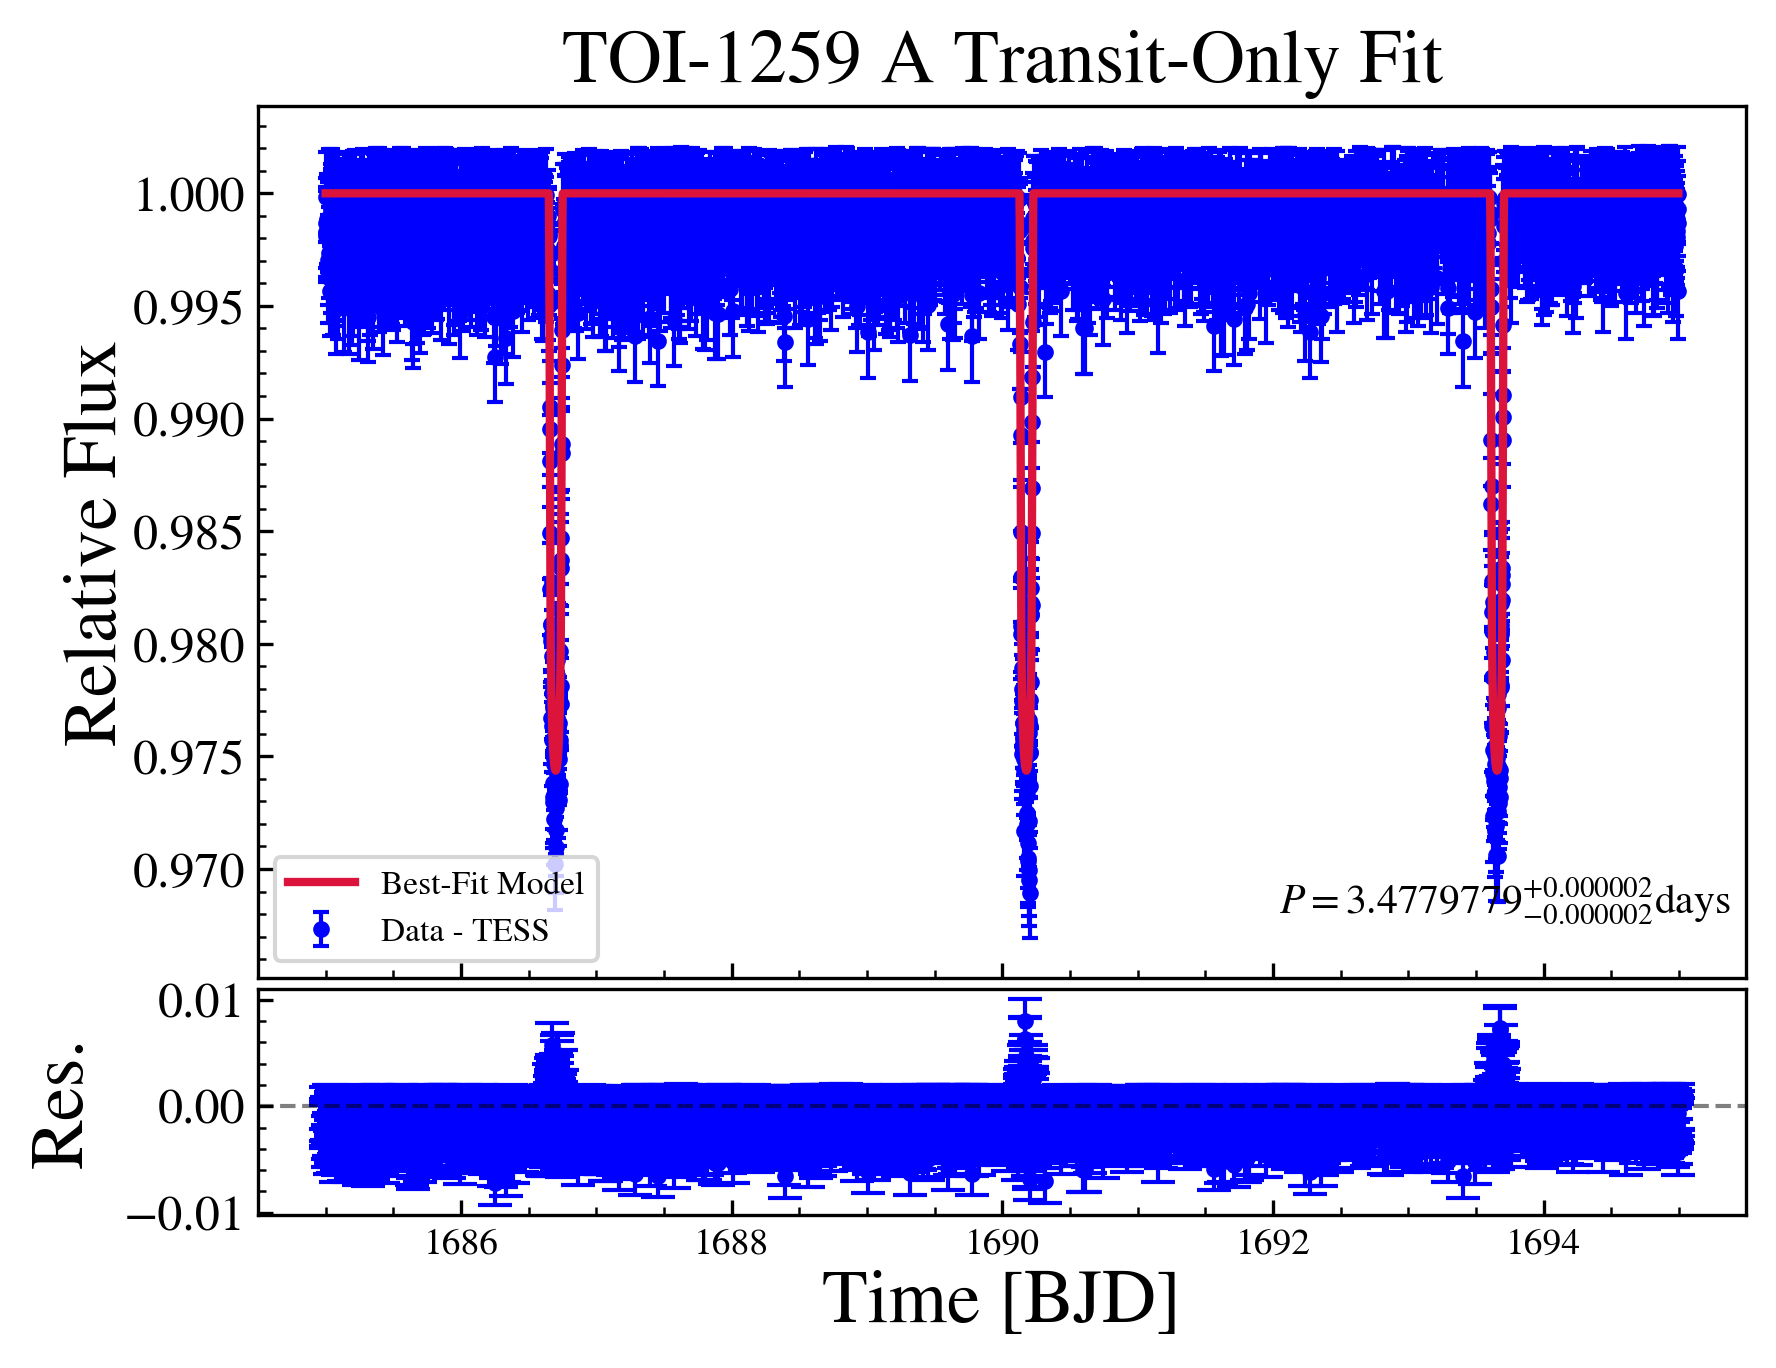

In [179]:
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"

#We can also add the model of RV uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]

#In this fit, it was varied.
uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]
inflated_tr_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(TF.lpf.data["x"], TF.lpf.data["y"], yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - TESS', zorder = -100)

#We also plot our best-fit model.
ax.plot(times_model, tr_model, color="crimson", label = "Best-Fit Model", lw=2., zorder=10)

#We then plot the residuals.
bx.errorbar(TF.lpf.data["x"], residuals, yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -100)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using tr_models_for_uncertainty.
#1 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 16, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 84, axis=0),
#                 color='#EE2C2C', alpha=0.3)
# #2 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 2, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 98, axis=0),
#                 color='#EE2C2C', alpha=0.2)
# #3 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 0.15, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 99.85, axis=0),
#                 color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('Relative Flux',labelpad=0,fontsize=18)
bx.set_xlabel('Time [BJD]',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]+0, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

### Plotting the Data and the Best-Fit Model over Phase

In [180]:
#To plot the Data and the Best-Fit model over Phase, we first need to get the Period and T0
#from the flatchains.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "t0_p1"].values[0]

#We can then use ExoMUSE_utils.time_to_phase(times, P, T0) function to convert the times
#to phase.
phase_data = ExoMUSE_utils.time_to_phase(times_data, P, T_0, phase_method="centered")

#We then convert the model times to phase too.
phase_model = ExoMUSE_utils.time_to_phase(times_model, P, T_0, phase_method="centered")

#We then have to sort the data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
tr_model_sorted = tr_model[sorted_indices]

In [181]:
#We can again the uncertainty intervals of our model.
#It is the same structure as before.

#For this we first define a list to store all of the Transit models.
tr_models_for_uncertainty_phase = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    model_sorted = model[sorted_indices]
    tr_models_for_uncertainty_phase.append(model_sorted)

#We then convert this list to an array.
tr_models_for_uncertainty_phase = np.array(tr_models_for_uncertainty_phase)

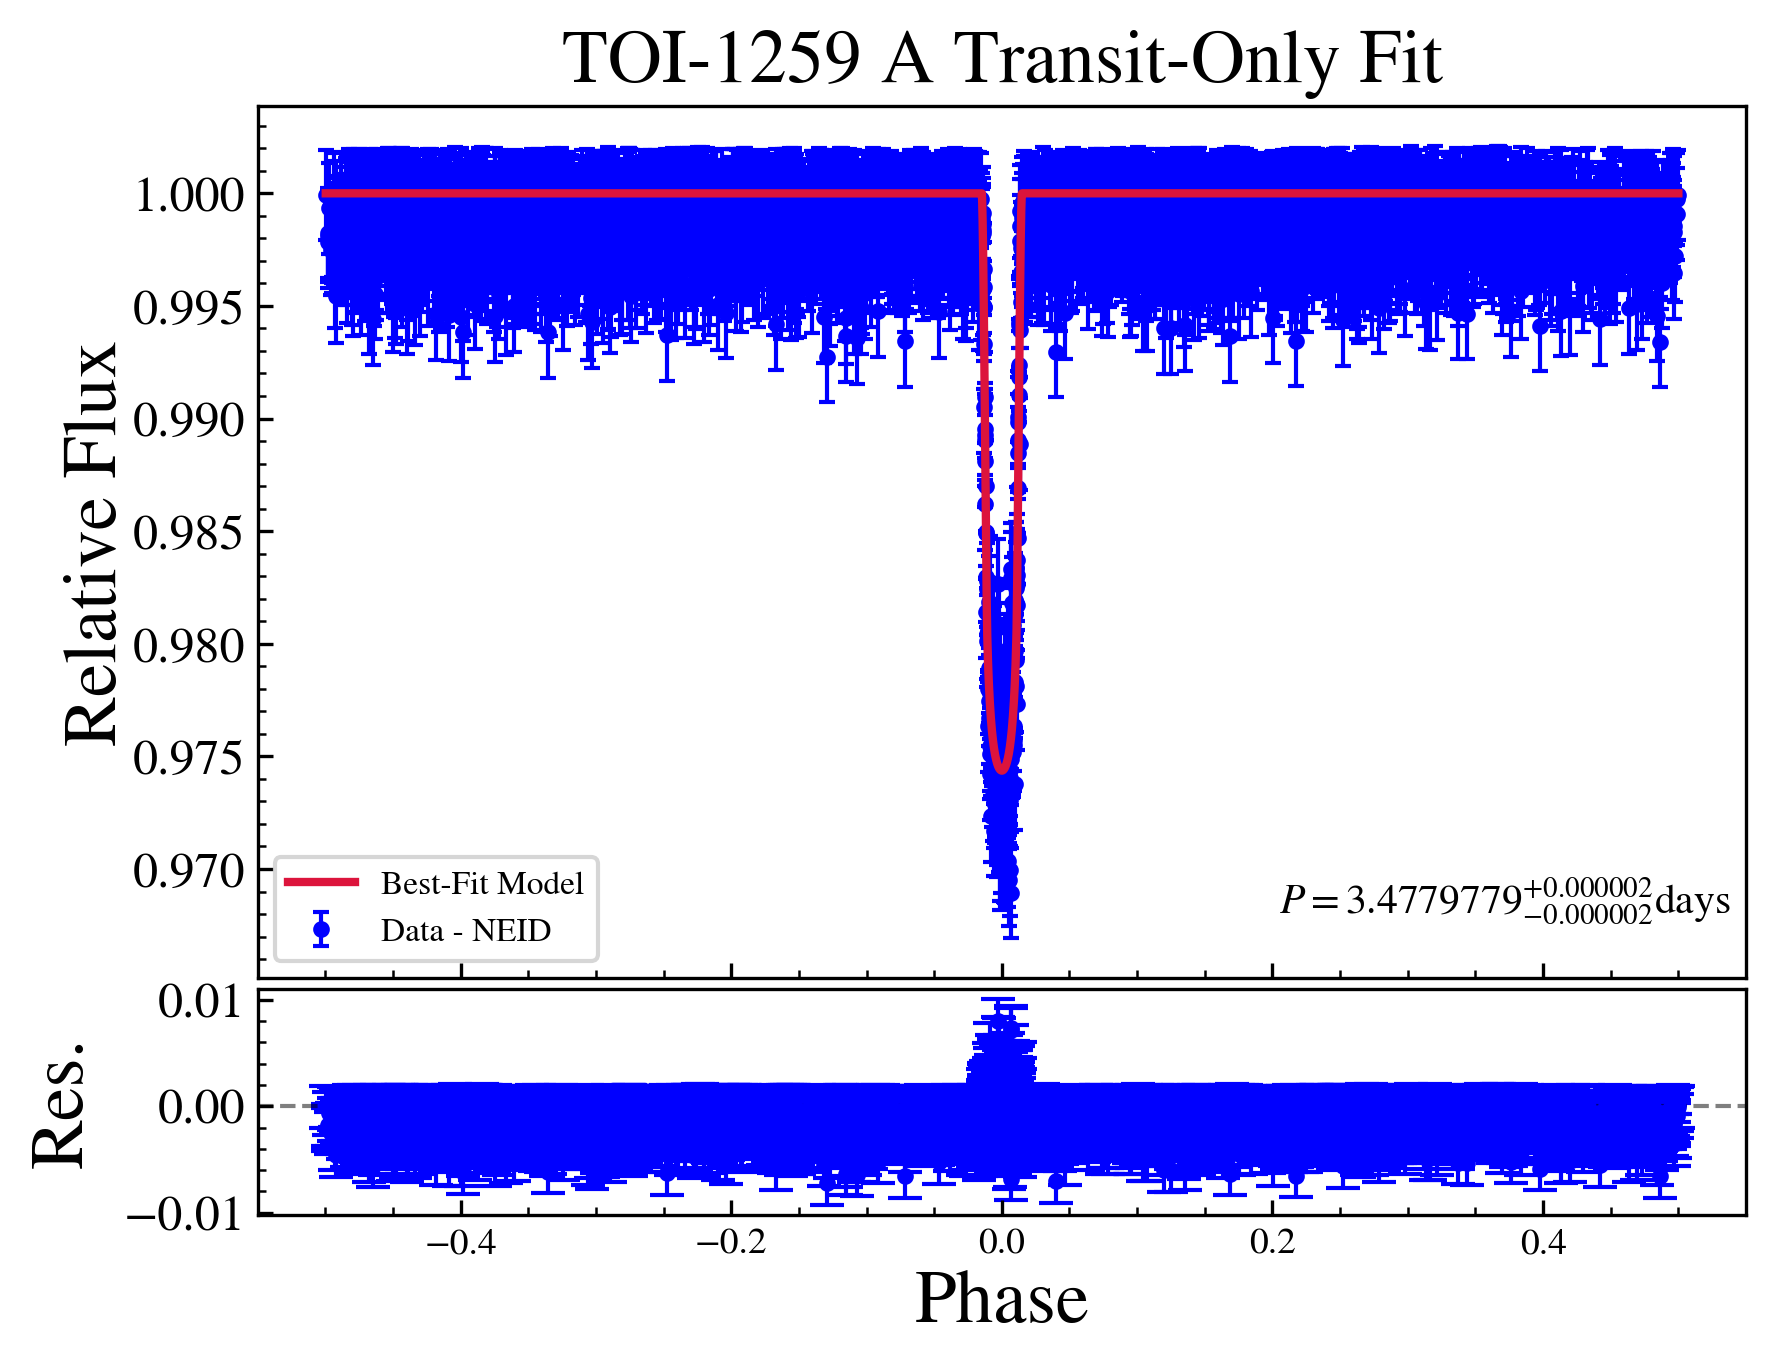

In [182]:
#We can then again plot the data as follows.
#We then plot our data.
#For this we define 2 rows with one of them for the Flux and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"

#We can also add the model of Flux uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]

#In this fit, it was varied.
uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]
inflated_tr_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(phase_data, TF.lpf.data["y"], yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - NEID', zorder = -10)

#We also plot our best-fit model.
ax.plot(phase_model_sorted, tr_model_sorted, color="crimson", label = "Best-Fit Model", lw=2., zorder=10)

#We then plot the residuals.
bx.errorbar(phase_data, residuals, yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the Transit graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using tr_models_for_uncertainty_phase.
#1 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 16, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 84, axis=0),
#                 color='#EE2C2C', alpha=0.3)
# #2 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 2, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 98, axis=0),
#                 color='#EE2C2C', alpha=0.2)
# #3 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 0.15, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 99.85, axis=0),
#                 color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('Relative Flux',labelpad=0,fontsize=18)
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]+0, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

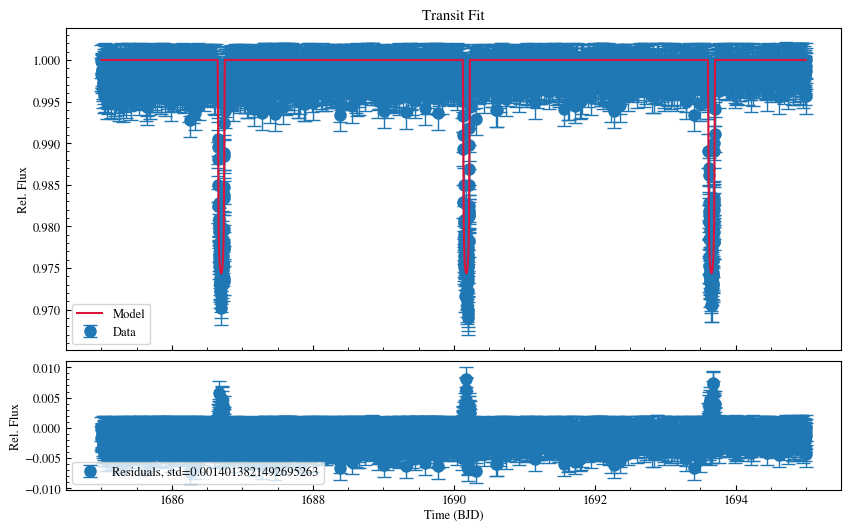

In [183]:
#If needed, it is also possible to quickly plot the best-fit model with a simple function inside ExoMUSE_fit.
    #pv: Parameter Values, add medial values.
    #times: Times that we want to evaluate the model on.
quick_plot = TF.plot_fit(pv = df_medvals["medvals"].values, times=times_model)
plt.show()